In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn import tree
from IPython.display import Image
import pydotplus
import os

import warnings

warnings.filterwarnings(action='ignore')

## --------------------------------------데이터불러온 후 준비----------------------------------

## 1. 데이터로드

In [2]:
data = pd.read_excel('C:/Users/lucky/바탕 화면/Capstone-Design/processed_data_2.xlsx',header=0)

In [3]:
data.drop(['mod_d'], axis='columns', inplace=True)

In [4]:
data.drop(['psu'], axis='columns', inplace=True)

In [5]:
data

,region,town_t,apt_t,sex,age,incm,ho_incm,incm5,ho_incm5,edu,...,LS_1YR,LK_EDU,LK_LB_CO,LK_LB_US,LK_LB_IT,LK_LB_EF,LF_secur_y,LF_BUYER,LF_SAFE,target
0,1,1,2,1,80,1,1,2,1,3,...,1,2,1,2,88,8,1,2,1,1
1,1,1,2,1,78,4,4,5,5,4,...,1,2,2,8,88,8,1,1,1,3
2,1,1,2,2,75,4,4,5,5,3,...,2,2,2,8,88,8,1,1,1,3
3,1,1,2,2,80,2,1,2,1,1,...,1,2,2,8,88,8,1,1,1,3
4,1,1,2,2,71,1,1,2,1,4,...,2,1,2,8,88,8,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,8,1,2,1,1,3,3,4,4,1,...,1,3,3,8,88,8,1,1,1,1
6074,8,1,2,2,73,2,1,2,1,1,...,2,2,1,2,88,8,1,1,1,1
6075,8,1,2,1,43,3,4,4,4,4,...,2,2,1,2,88,8,1,1,2,3
6076,8,1,2,1,10,3,4,4,4,1,...,2,2,2,8,88,8,1,1,2,3


## 2. 클래스분리

In [6]:
Ttrain = data.drop('target',axis=1)
Ttarget = data['target']

## 3. Min-Max 스케일링

In [7]:
# min - max 스케일링
mm = MinMaxScaler()
mm = mm.fit(Ttrain)
Ttrain = mm.transform(Ttrain)

In [8]:
Ttrain

array([[0.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4375    , 0.        , 1.        , ..., 0.        , 0.        ,
        0.33333333],
       [0.4375    , 0.        , 1.        , ..., 0.        , 0.        ,
        0.33333333],
       [0.4375    , 0.        , 1.        , ..., 0.        , 0.        ,
        0.33333333]])

In [9]:
print(Ttrain.shape)

(6078, 365)


## 4. k-fold 적용

In [10]:
folds = 5
KF = KFold(n_splits = folds, shuffle = True, random_state=42)

## 5. model 적용 준비하기

In [11]:
xgb_avg = 0
lgb_avg = 0
cat_avg = 0

xgb_preds = np.zeros([Ttrain.shape[0],])
lgb_preds = np.zeros([Ttrain.shape[0],])
cat_preds = np.zeros([Ttrain.shape[0],])

## -----------------------------------------모델 적용하기-------------------------------------

In [12]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_score(pred, test):
    print('MSE:',mean_squared_error(pred,test))
    print('MAE:',mean_absolute_error(pred,test))
    print('r2_score:',r2_score(pred,test))
    print('MAPE:',mape(pred,test))

In [13]:
cat_params = {
    'iterations':1000,
    'learning_rate':0.05,
    'depth':16,
    'loss_function':'MAE',
    'eval_metric':'MAPE',
    'thread_count':16,
    'rsm':0.95,
    'bagging_temperature':0.8
}
    
for i,(train_ind, test_ind) in enumerate(KF.split(Ttrain)):
    print('========Fold',i+1)
    Xtrain, XCV, ytrain, yCV = Ttrain[train_ind], Ttrain[test_ind], Ttarget[train_ind], Ttarget[test_ind]
    
    cat_model = cat.CatBoostRegressor(**cat_params)
    
    cat_model.fit(Xtrain,ytrain,eval_set=[(XCV,yCV)],early_stopping_rounds=30,verbose=False)
    
    pred = cat_model.predict(XCV)
    
    print_score(pred,yCV)
    
    cat_preds += cat_model.predict(Ttrain)/folds
    cat_avg += mape(pred,yCV)/folds

print('\n\nAverage MAPE Score:',cat_avg)

========Fold 1
MSE: 0.5487788466498723
MAE: 0.5197986774164935
r2_score: -4.056792093554556
MAPE: 20.640743140716317
========Fold 2
MSE: 0.5468325224872583
MAE: 0.5184579913564363
r2_score: -4.728380723498268
MAPE: 20.374093742891155
========Fold 3
MSE: 0.5694907602550747
MAE: 0.5364654382499774
r2_score: -4.838840236393213
MAPE: 21.249550457156975
========Fold 4
MSE: 0.5020029116725844
MAE: 0.5054230903061918
r2_score: -4.030780863556386
MAPE: 20.217032156275167
========Fold 5
MSE: 0.5376470578131551
MAE: 0.5215523181958553
r2_score: -5.028990986173126
MAPE: 20.441952090225527


Average MAPE Score: 20.584674317453025


In [14]:
xgb_params = {
    'n_estimators':1000,
    'learning_rate':0.05,
    'gamma':0,
    'subsample':0.75,
    'max_depth':10,
}

def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return np.mean(np.abs((labels - preds) / (labels)))*100

for i,(train_ind, test_ind) in enumerate(KF.split(Ttrain)):
    print('========Fold',i+1)
    Xtrain, XCV, ytrain, yCV = Ttrain[train_ind], Ttrain[test_ind], Ttarget[train_ind], Ttarget[test_ind]
    
    xgb_model = xgb.XGBRegressor(**xgb_params)
    
    xgb_model.fit(Xtrain,ytrain,eval_set=[(XCV,yCV)],eval_metric=['rmse','mae'],early_stopping_rounds=30,verbose=False)
    
    pred = xgb_model.predict(XCV)
    
    print_score(pred,yCV)
    
    xgb_preds += xgb_model.predict(Ttrain)/folds
    xgb_avg += mape(pred,yCV)/folds
    

print('\n\nAverage MAPE Score:',xgb_avg)

========Fold 1
MSE: 0.5265865873966912
MAE: 0.5523328666428202
r2_score: -2.5806786315124857
MAPE: 23.548437073002827
========Fold 2
MSE: 0.5047007555361441
MAE: 0.5486963409930468
r2_score: -2.7331287269594657
MAPE: 23.561690665880757
========Fold 3
MSE: 0.53824396684135
MAE: 0.5631370831673083
r2_score: -3.0853879552177963
MAPE: 24.079258076281597
========Fold 4
MSE: 0.4849203237213833
MAE: 0.5415756960955176
r2_score: -2.12132953544149
MAPE: 23.77523874271958
========Fold 5
MSE: 0.5166764556936739
MAE: 0.555695651588126
r2_score: -2.624227987444484
MAPE: 24.026136864174074


Average MAPE Score: 23.798152284411763


In [15]:
lgb_params = {
    'n_estimators':1000,
    'num_leaves':20,
    'learning_rate':0.05,
    'max_depth':100,
    'boosting_type':'gbdt',
    'n_jobs':-1
}

for i,(train_ind, test_ind) in enumerate(KF.split(Ttrain)):
    print('========Fold',i+1)
    Xtrain, XCV, ytrain, yCV = Ttrain[train_ind], Ttrain[test_ind], Ttarget[train_ind], Ttarget[test_ind]
    
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    
    lgb_model.fit(Xtrain,ytrain,eval_set=[(XCV,yCV)],eval_metric='mape',early_stopping_rounds=30,verbose=False)
    
    pred = lgb_model.predict(XCV)
    
    print_score(pred,yCV)
    
    lgb_preds += lgb_model.predict(Ttrain)/folds
    lgb_avg += mape(pred,yCV)/folds

print('\n\nAverage MAPE Score:',lgb_avg)

========Fold 1
MSE: 0.49123231336038264
MAE: 0.5568298440789896
r2_score: -4.750458412538226
MAPE: 23.03234260170159
========Fold 2
MSE: 0.4717721439723485
MAE: 0.5375853673750294
r2_score: -3.2724842561497667
MAPE: 22.62020302455381
========Fold 3
MSE: 0.5101060936707984
MAE: 0.561004011406331
r2_score: -4.041910109502341
MAPE: 23.46933503167314
========Fold 4
MSE: 0.45971994904098845
MAE: 0.5508240114253717
r2_score: -4.437681642109127
MAPE: 23.022023165338656
========Fold 5
MSE: 0.49250744298691085
MAE: 0.5592966720040727
r2_score: -5.542682927096563
MAPE: 23.01544764552648


Average MAPE Score: 23.031870293758736


## --------------------------------------------feature importance-----------------------------------------
### - train set으로 첫번째 모델 학습 후, 가장 설명력이 좋은 모델(cat boost)로 feature importance 한다.
### - 그 후 해당 변수로만 모델 학습 한 후, 다음 assemble 단계로 넘어간다.

In [16]:
trainset = data.drop('target',axis=1)

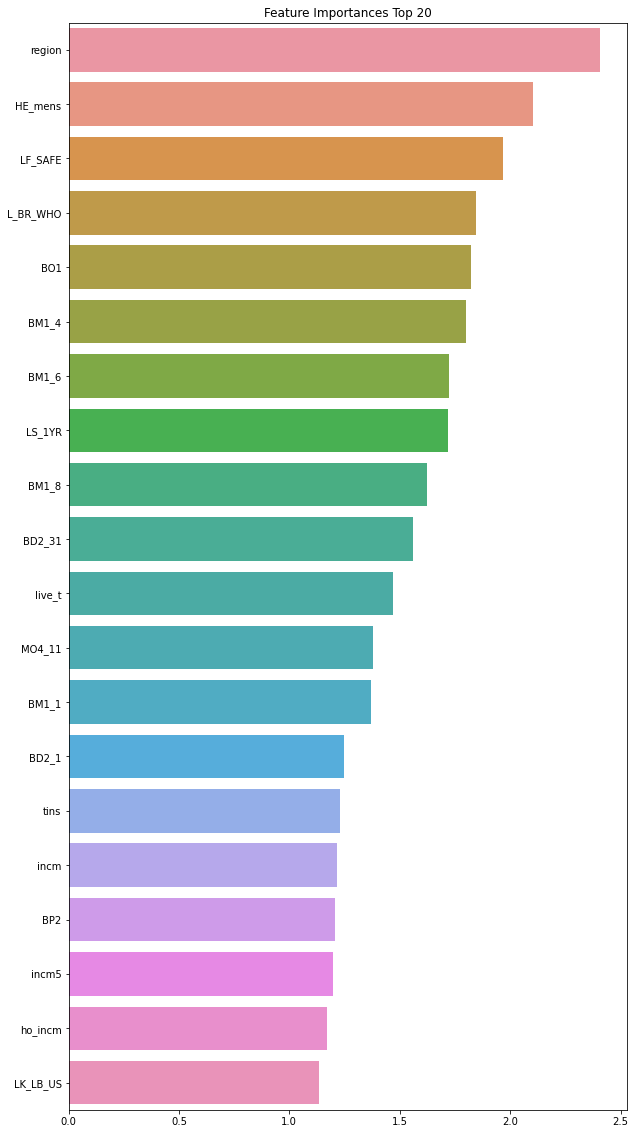

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feature_importance_values = cat_model.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=trainset.columns)
# 중요도값 순으로 Series를 정렬
feature_top20 = feature_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=[10, 20])
plt.title('Feature Importances Top 20')
sns.barplot(x=feature_top20, y=feature_top20.index)
plt.show()

### feature importance 결과
1. region : 17개 시도
2. HE_mens : 생리여부
3. LF_SAFE : 식생활형편
4. L_BR_WHO : 최근 1년 동안 아침식사 시 동반 대상
5. BO1 : 주관적 체형 인식
6. BM1_4 : 칫솔질 시기-점심식사 후
7. BM1_6 : 칫솔질 시기-저녁식사 후
8. LS_1YR : 최근 1년 동안 2주 이상 식이보충제 복용여부
9. BM1_8 : 칫솔질 시기-잠자기 전
10. BD2_31 : (만 12세 이상) 폭음 빈도

## --------------------------------위 TOP10변수로 구글 DOCS를 통한 설문조사---------------------------

최종적으로 50명의 설문자에게 설문답변을 받았고, 해당 답변에 대한 데이터셋을 구성 후 survey로 저장함

## ----------------------------------------survey에 대한 나트륨위험군 예측---------------------------------------


10개의 attribute로 이뤄진 데이터셋을 processed_data_3로 저장하고 이를 토대로 모델을 다시 학습시킨다.   
또한 survey 데이터셋의 target(고:3, 중:2, 저:2) 예측값을 데이터셋에 채운다.

In [45]:
train = pd.read_excel('C:/Users/lucky/바탕 화면/Capstone-Design/processed_data_3.xlsx',header=0)
test = pd.read_excel('C:/Users/lucky/바탕 화면/Capstone-Design/survey.xlsx',header=0)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [46]:
train.head()

,region,BO1,BD2_31,HE_mens,BM1_4,BM1_6,BM1_8,L_BR_WHO,LS_1YR,LF_SAFE,target
0,1,4,1,8,0,1,0,1,1,1,1
1,1,4,3,8,0,0,0,1,1,1,3
2,1,4,8,0,0,1,0,1,2,1,3
3,1,3,8,0,0,1,0,1,1,1,3
4,1,2,8,0,0,1,0,8,2,1,1


In [47]:
test.head()

,region,BO1,BD2_31,HE_mens,BM1_4,BM1_6,BM1_8,L_BR_WHO,LS_1YR,LF_SAFE,target
0,1,2,8,0,0,1,0,8,1,2,NaN
1,8,4,8,0,0,1,0,8,1,2,NaN
2,8,4,8,0,1,1,1,8,1,2,NaN
3,6,3,2,8,0,1,0,8,2,2,NaN
4,8,4,2,0,1,1,0,1,1,1,NaN


In [48]:
print(train.shape, test.shape)

(6078, 11) (53, 11)


In [49]:
Ttrain = train.drop('target',axis=1)
Ttarget = train['target']
Ttest = test.drop('target',axis=1)

In [50]:
# min - max 스케일링
mm = MinMaxScaler()
mm = mm.fit(Ttrain)
Ttrain = mm.transform(Ttrain)
Ttest = mm.transform(Ttest)

In [51]:
Ttrain

array([[0.        , 0.375     , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.375     , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.375     , 0.875     , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.4375    , 0.5       , 0.375     , ..., 1.        , 1.        ,
        0.33333333],
       [0.4375    , 0.25      , 0.875     , ..., 0.        , 1.        ,
        0.33333333],
       [0.4375    , 0.375     , 0.875     , ..., 0.        , 1.        ,
        0.33333333]])

In [52]:
Ttest

array([[0.        , 0.125     , 0.875     , 0.        , 0.        ,
        0.11111111, 0.        , 1.        , 0.        , 0.33333333],
       [0.4375    , 0.375     , 0.875     , 0.        , 0.        ,
        0.11111111, 0.        , 1.        , 0.        , 0.33333333],
       [0.4375    , 0.375     , 0.875     , 0.        , 0.11111111,
        0.11111111, 0.11111111, 1.        , 0.        , 0.33333333],
       [0.3125    , 0.25      , 0.125     , 1.        , 0.        ,
        0.11111111, 0.        , 1.        , 1.        , 0.33333333],
       [0.4375    , 0.375     , 0.125     , 0.        , 0.11111111,
        0.11111111, 0.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.25      , 0.875     , 1.        , 0.11111111,
        0.11111111, 0.        , 0.        , 0.        , 0.        ],
       [0.0625    , 0.25      , 0.875     , 0.        , 0.11111111,
        0.11111111, 0.        , 0.        , 0.        , 0.        ],
       [0.4375    , 0.875     , 0.875    

In [53]:
print(Ttrain.shape, Ttest.shape)

(6078, 10) (53, 10)


In [54]:
folds = 5
KF = KFold(n_splits = folds, shuffle = True, random_state=42)

In [55]:
xgb_avg = 0
lgb_avg = 0
cat_avg = 0

xgb_preds = np.zeros([Ttrain.shape[0],])
lgb_preds = np.zeros([Ttrain.shape[0],])
cat_preds = np.zeros([Ttrain.shape[0],])

In [58]:
cat_params = {
    'iterations':1000,
    'learning_rate':0.05,
    'depth':16,
    'loss_function':'MAE',
    'eval_metric':'MAPE',
    'thread_count':16,
    'rsm':0.95,
    'bagging_temperature':0.8
}
    
for i,(train_ind, test_ind) in enumerate(KF.split(Ttrain)):
    print('========Fold',i+1)
    Xtrain, XCV, ytrain, yCV = Ttrain[train_ind], Ttrain[test_ind], Ttarget[train_ind], Ttarget[test_ind]
    
    cat_model = cat.CatBoostRegressor(**cat_params)
    
    cat_model.fit(Xtrain,ytrain,eval_set=[(XCV,yCV)],early_stopping_rounds=30,verbose=False)
    
    pred = cat_model.predict(XCV)
    
    print_score(pred,yCV)
    
    cat_preds += cat_model.predict(Ttrain)/folds
    cat_avg += mape(pred,yCV)/folds

print('\n\nAverage MAPE Score:',cat_avg)

========Fold 1
MSE: 0.6563091036776785
MAE: 0.521576398214462
r2_score: -3.5776613262294017
MAPE: 20.680241586941133
========Fold 2
MSE: 0.6537029333305872
MAE: 0.5251463928703767
r2_score: -2.918047510519038
MAPE: 21.33076207816893
========Fold 3
MSE: 0.7080364539678804
MAE: 0.5607114652189236
r2_score: -3.3178147657742114
MAPE: 22.76938691725599
========Fold 4
MSE: 0.604895524260152
MAE: 0.4923668597925937
r2_score: -4.471887940437386
MAPE: 19.117294853429367
========Fold 5
MSE: 0.6614389827523742
MAE: 0.5316156737365236
r2_score: -4.2544136460523605
MAPE: 20.83346222230959


Average MAPE Score: 20.946229531621


In [59]:
xgb_params = {
    'n_estimators':1000,
    'learning_rate':0.05,
    'gamma':0,
    'subsample':0.75,
    'max_depth':10,
}

def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return np.mean(np.abs((labels - preds) / (labels)))*100

for i,(train_ind, test_ind) in enumerate(KF.split(Ttrain)):
    print('========Fold',i+1)
    Xtrain, XCV, ytrain, yCV = Ttrain[train_ind], Ttrain[test_ind], Ttarget[train_ind], Ttarget[test_ind]
    
    xgb_model = xgb.XGBRegressor(**xgb_params)
    
    xgb_model.fit(Xtrain,ytrain,eval_set=[(XCV,yCV)],eval_metric=['rmse','mae'],early_stopping_rounds=30,verbose=False)
    
    pred = xgb_model.predict(XCV)
    
    print_score(pred,yCV)
    
    xgb_preds += xgb_model.predict(Ttrain)/folds
    xgb_avg += mape(pred,yCV)/folds
    

print('\n\nAverage MAPE Score:',xgb_avg)

========Fold 1
MSE: 0.6024478775323262
MAE: 0.5932622722497112
r2_score: -2.4701323478911665
MAPE: 26.031180365385453
========Fold 2
MSE: 0.6058659036030285
MAE: 0.5930045569119485
r2_score: -2.056517614836222
MAPE: 26.580717328715775
========Fold 3
MSE: 0.6015028815482841
MAE: 0.6028559861312571
r2_score: -2.7687434852502366
MAPE: 26.227803494510987
========Fold 4
MSE: 0.5736354801086921
MAE: 0.5755406320830923
r2_score: -2.506212865372216
MAPE: 25.091750485257887
========Fold 5
MSE: 0.6137209469031722
MAE: 0.5991727313877624
r2_score: -2.924522818224897
MAPE: 25.761208619590775


Average MAPE Score: 25.93853205869218


In [60]:
lgb_params = {
    'n_estimators':1000,
    'num_leaves':20,
    'learning_rate':0.05,
    'max_depth':100,
    'boosting_type':'gbdt',
    'n_jobs':-1
}

for i,(train_ind, test_ind) in enumerate(KF.split(Ttrain)):
    print('========Fold',i+1)
    Xtrain, XCV, ytrain, yCV = Ttrain[train_ind], Ttrain[test_ind], Ttarget[train_ind], Ttarget[test_ind]
    
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    
    lgb_model.fit(Xtrain,ytrain,eval_set=[(XCV,yCV)],eval_metric='mape',early_stopping_rounds=30,verbose=False)
    
    pred = lgb_model.predict(XCV)
    
    print_score(pred,yCV)
    
    lgb_preds += lgb_model.predict(Ttrain)/folds
    lgb_avg += mape(pred,yCV)/folds

print('\n\nAverage MAPE Score:',lgb_avg)

========Fold 1
MSE: 0.5175248393083699
MAE: 0.5863287068686571
r2_score: -7.9502753415354075
MAPE: 23.908304692353543
========Fold 2
MSE: 0.5232261764326619
MAE: 0.5927395673811425
r2_score: -7.838508327457912
MAPE: 24.293847770571308
========Fold 3
MSE: 0.5425352996423215
MAE: 0.5891387777684948
r2_score: -6.792384183993595
MAPE: 24.102628331269624
========Fold 4
MSE: 0.49035873148197184
MAE: 0.5705975366771308
r2_score: -5.903565361500595
MAPE: 23.544614566640202
========Fold 5
MSE: 0.5188857242619225
MAE: 0.582155056442828
r2_score: -7.804125929642607
MAPE: 23.69095964643116


Average MAPE Score: 23.908071001453166


## --------------------------------------------assemble-----------------------------------------

In [77]:
total_preds = (xgb_preds + lgb_preds + cat_preds)/3
total_preds.shape

(6078,)

In [78]:
total_preds = list(total_preds)

In [79]:
submission = pd.read_excel('C:/Users/lucky/바탕 화면/Capstone-Design/survey.xlsx',header=0)

In [80]:
count = 0
for idx in range(len(submission)):
    submission.loc[idx,'target'] = total_preds[count]
    count+=1
    if count==53:
        break

In [81]:
submission

,region,BO1,BD2_31,HE_mens,BM1_4,BM1_6,BM1_8,L_BR_WHO,LS_1YR,LF_SAFE,target
0,1,2,8,0,0,1,0,8,1,2,2.460075
1,8,4,8,0,0,1,0,8,1,2,2.918231
2,8,4,8,0,1,1,1,8,1,2,2.692170
3,6,3,2,8,0,1,0,8,2,2,2.699686
4,8,4,2,0,1,1,0,1,1,1,1.907052
5,9,3,8,8,1,1,0,1,1,1,2.806333
6,2,3,8,0,1,1,0,1,1,1,2.156131
7,8,8,8,8,1,1,0,1,1,1,2.592420
8,8,4,8,0,0,1,0,8,2,1,2.881933
9,1,2,1,8,1,1,0,8,1,1,2.434706


In [84]:
submission.to_excel('C:/Users/lucky/바탕 화면/Capstone-Design/survey_result.xlsx',index=False)